In [1]:
import os
import pickle
from joblib import Parallel, delayed

import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.CPQAOA import CP_QAOA
from src.QAOA import QAOA
from src.Grid import Grid
from src.Chain import Chain
from src.Tools import (portfolio_metrics, 
                       min_cost_partition, 
                       get_qubo, 
                       normalized_cost, 
                       qubo_limits, 
                       check_qubo,
                       partitioned_averages)

In [2]:
def simulate(datapoint):
    N,k,alpha,max_iter,my_topology,w_nnn,seed,N_layers = datapoint
    
    # Generating random problem instance 
    expected_returns, covariances = portfolio_metrics(n=N, seed=seed)
    
    # Retrieving C_min, C_max and corresponding states.
    constrained_result, full_result, lmbda = min_cost_partition(nr_qubits=N,
                                                                k=k,
                                                                mu=expected_returns,
                                                                sigma=covariances,
                                                                alpha=alpha)
    
    portfolio_subspace_max_cost, portfolio_subspace_min_cost, portfolio_subspace_min_state = constrained_result['c_max'], constrained_result['c_min'], constrained_result['s']
    portfolio_subspace_min_state_str = ''.join([str(_) for _ in portfolio_subspace_min_state])
    
    # Generating QUBO corresponding to current problem instance
    Q, offset = get_qubo(mu=expected_returns,
                         sigma=covariances,
                         alpha=alpha,
                         lmbda=lmbda+1e-8,
                         k=k)
    
    QUBO_limits = qubo_limits(Q=Q,offset=offset)
    qubo_min_cost, qubo_max_cost = QUBO_limits['c_min'], QUBO_limits['c_max']
    qubo_min_state, qubo_max_state = QUBO_limits['min_state'], QUBO_limits['max_state']
    check_qubo(QUBO_matrix=Q, QUBO_offset=offset, expected_returns=expected_returns, covariances=covariances, alpha=alpha, k=k)
    qubo_min_state_str = ''.join([str(_) for _ in qubo_min_state])
    
    if not portfolio_subspace_min_state_str == qubo_min_state_str:
        raise RuntimeError(f'portfolio_subspace_min_state_str: {portfolio_subspace_min_state_str}, qubo_min_state_str={qubo_min_state_str}'+f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not np.isclose(qubo_min_cost,portfolio_subspace_min_cost):
        raise RuntimeError(f'Min. cost of qubo is: {qubo_min_cost}, but min. cost of constrained portfolio is: {portfolio_subspace_min_cost}.')
    
    if not qubo_max_cost >= portfolio_subspace_max_cost:
        raise RuntimeError(f'Max. cost of qubo: {qubo_max_cost}, max. cost of portfolio subspace: {portfolio_subspace_max_cost} (should be qubo max. >= constrained portfolio max)')
    
    # Defining method for scipy optimizer
    optimizer_method = 'COBYLA'
    
    # Generating instances of ansatz'
    CP_z_phase_ansatz = CP_QAOA(N_qubits=N,
                     cardinality=k,
                     layers=N_layers,
                     topology=my_topology,
                     QUBO_matrix=Q,
                     with_next_nearest_neighbors=w_nnn,
                     with_z_phase=True)
    
    NORMAL_ansatz = QAOA(N_qubits=N,
                     layers=N_layers,
                     QUBO_matrix=Q,
                     QUBO_offset=offset)
    
    
    # Generating callback function for plotting
    CP_z_phase_costs = [] # Normalized costs
    CP_z_phase_probs = [] # probability of optimal state
    def CP_z_phase_callback_function(x):
        _dict_ = CP_z_phase_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            CP_z_phase_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            CP_z_phase_probs.append(0)
        CP_z_phase_costs.append(_cost_)
    
    # Generating initial guess for rotation angles for CP_ansatz
    theta_min, theta_max = -2*np.pi, 2*np.pi
    N_angles = N_layers * len(my_topology.get_NN_indices())
    if w_next_nearest_neighbors:
        N_angles += N_layers * (N - 2)
    N_angles += N_layers * N # Because this is WITH Z-phase
    CP_z_phase_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    # Performing optimization
    CP_z_phase_res = sc.optimize.minimize(fun=CP_z_phase_ansatz.get_cost, x0=CP_z_phase_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=CP_z_phase_callback_function)
    
    # Generating callback function for plotting
    NORMAL_costs = [] # Normalized costs
    NORMAL_probs = [] # probability of optimal state
    def NORMAL_callback_function(x):
        _dict_ = NORMAL_ansatz.get_state_probabilities(flip_states=False)
        # N.B. Normalizing w. respect to full space max cost
        _cost_ = normalized_cost(result=_dict_,
                                 QUBO_matrix=Q,
                                 QUBO_offset=offset,
                                 max_cost=portfolio_subspace_max_cost, 
                                 min_cost=qubo_min_cost)
        if portfolio_subspace_min_state_str in list(_dict_.keys()):
            NORMAL_probs.append(_dict_[portfolio_subspace_min_state_str])
        else:
            NORMAL_probs.append(0)
        NORMAL_costs.append(_cost_)
    
    # For normal QAOA w. need "layers" nr. of angles for both 'beta' and 'gamma'
    N_angles = 2 * N_layers 
    NORMAL_theta_i = np.random.uniform(low=theta_min, high=theta_max, size=N_angles)
    
    NORMAL_res = sc.optimize.minimize(fun=NORMAL_ansatz.get_cost, x0=NORMAL_theta_i,
                               method=optimizer_method,
                               options={'disp': False, 'maxiter': max_iter},
                               callback=NORMAL_callback_function)
    
    
    return {'(N,k,alpha,max_iter,my_topology,w_nnn,seed,N_layers)': datapoint,
            'QAOA': (NORMAL_probs,NORMAL_costs,NORMAL_res),
            'CP_VQA_Z_PHASE': (CP_z_phase_probs, CP_z_phase_costs, CP_z_phase_res)}


In [3]:
# Number of Qubits 
N_vals = [4,5,6,7,8,9,10,11,12,13,14,15]
# alpha in: s^T*mu + alpha*(s^T*Covar*s)
alpha=0.5
# Maximal number of iterations for classical solver
max_iter=1000
# Using next nearest neighbors (in 1D chain model)
w_next_nearest_neighbors = True
# Number of layer repetitions
N_layers = 3


initialization_strategies = [np.array([0,1,0,1]),
                             np.array([0,1,0,1,0]),
                             np.array([0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0,1,0,1,0,1,0]),
                             np.array([0,1,0,1,0,1,0,1,0,1,0,1,0,1]),
                             np.array([0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])]


N_SEEDS = 50
N_jobs = os.cpu_count()-1

datapoints = []
for seed in range(N_SEEDS):
    n_counter = 0
    for N in N_vals:
        k = N // 2
        my_topology = Chain(N_qubits=N)
        my_topology.set_initialization_strategy(strategy=initialization_strategies[n_counter])
        dp = (N,k,alpha,max_iter,my_topology,w_next_nearest_neighbors,seed,N_layers)
        datapoints.append(dp)
        n_counter += 1
        
r = Parallel(n_jobs=N_jobs, verbose=51, backend='loky')(delayed(simulate)(datapoint) for datapoint in datapoints)

for idx,result in enumerate(r):
    filename = f'fig_8_results/res_{idx}.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(result, file)

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=15)]: Done   3 tasks      | elapsed:  1.5min
[Parallel(n_jobs=15)]: Done   4 tasks      | elapsed:  1.8min
[Parallel(n_jobs=15)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=15)]: Done   6 tasks      | elapsed:  2.5min
[Parallel(n_jobs=15)]: Done   7 tasks      | elapsed:  2.5min
[Parallel(n_jobs=15)]: Done   8 tasks      | elapsed:  3.0min
[Parallel(n_jobs=15)]: Done   9 tasks      | elapsed:  3.7min
[Parallel(n_jobs=15)]: Done  10 tasks      | elapsed:  4.0min
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  4.2min
[Parallel(n_jobs=15)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=15)]: Done  13 tasks      | elapsed:  5.0min
[Parallel(n_jobs=15)]: Done  14 tasks      | elapsed:  5.3min
[Parallel(n_jobs=15)]: Done  15 tasks      | elapsed:  

In [2]:
results = []
for filename in os.listdir('fig_8_results'):
    with open('fig_8_results/'+filename, 'rb') as file:
        results.append(pickle.load(file))

In [3]:
N_values = [4,5,6,7,8,9,10,11,12,13,14,15]
QAOA_probs, QAOA_costs = {f'N={N}':[] for N in N_values}, {f'N={N}':[] for N in N_values}
CP_VQA_probs, CP_VQA_costs = {f'N={N}':[] for N in N_values}, {f'N={N}':[] for N in N_values}
for result in results:
    _N_ = result['(N,k,alpha,max_iter,my_topology,w_nnn,seed,N_layers)'][0]
    p_qaoa,c_qaoa,res_qaoa = result['QAOA']
    QAOA_probs[f'N={_N_}'].append(np.max(p_qaoa))
    QAOA_costs[f'N={_N_}'].append(np.min(c_qaoa))
    
    p_cp_vqa,c_cp_vqa,res_cp_vqa = result['CP_VQA_Z_PHASE']
    CP_VQA_probs[f'N={_N_}'].append(np.max(p_cp_vqa))
    CP_VQA_costs[f'N={_N_}'].append(np.min(c_cp_vqa))

for N in N_values:
    mu, std = np.mean(QAOA_probs[f'N={N}']), np.std(QAOA_probs[f'N={N}'])
    QAOA_probs[f'N={N}'] = mu, std
    
    mu, std = np.mean(QAOA_costs[f'N={N}']), np.std(QAOA_costs[f'N={N}'])
    QAOA_costs[f'N={N}'] = mu, std
    
    mu, std = np.mean(CP_VQA_probs[f'N={N}']), np.std(CP_VQA_probs[f'N={N}'])
    CP_VQA_probs[f'N={N}'] = mu, std
    
    mu, std = np.mean(CP_VQA_costs[f'N={N}']), np.std(CP_VQA_costs[f'N={N}'])
    CP_VQA_costs[f'N={N}'] = mu, std

In [4]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{amssymb}\usepackage{physics}'
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

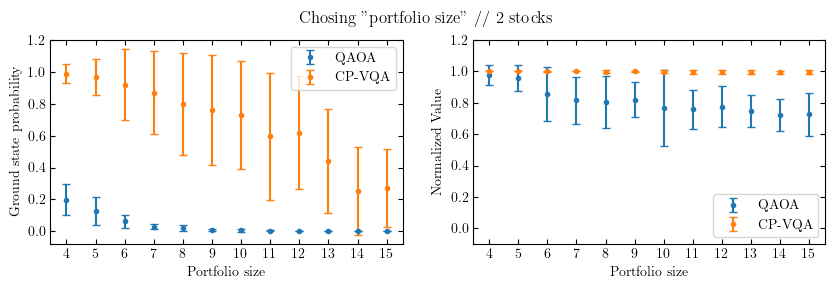

In [7]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
fig.suptitle('Chosing "portfolio size" // 2 stocks')
fig.subplots_adjust(bottom=0.2)
ax[0].errorbar(N_values, [QAOA_probs[f'N={N}'][0] for N in N_values], yerr=[QAOA_probs[f'N={N}'][1] for N in N_values], fmt='.', capsize=3,label='QAOA', )
ax[0].errorbar(N_values, [CP_VQA_probs[f'N={N}'][0] for N in N_values], yerr=[CP_VQA_probs[f'N={N}'][1] for N in N_values], fmt='.', capsize=3, label='CP-VQA')
ax[0].legend(loc='upper right')
ax[0].set_xticks(N_values)
ax[0].set_xlabel('Portfolio size')
ax[0].set_ylabel('Ground state probability')

ax[1].errorbar(N_values, [1-QAOA_costs[f'N={N}'][0] for N in N_values], yerr=[QAOA_costs[f'N={N}'][1] for N in N_values], fmt='.', capsize=3,label='QAOA', )
ax[1].errorbar(N_values, [1-CP_VQA_costs[f'N={N}'][0] for N in N_values], yerr=[CP_VQA_costs[f'N={N}'][1] for N in N_values], fmt='.', capsize=3, label='CP-VQA')
ax[1].legend(loc='lower right')
ax[1].set_xticks(N_values)
ax[1].set_ylim(-0.1,1.2)
ax[1].set_xlabel('Portfolio size')
ax[1].set_ylabel('Normalized Value')

plt.savefig('fig_8.png', dpi=300)
plt.show()